# Setup some tooling for running simulations
I copied parts of this from [another notebook](../eval/igraph-runner-demo.ipynb). At some point, we probably want to extract the relevant bits into a shared python script or module.

In [1]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

# %matplotlib notebook
%matplotlib inline

In [2]:
def sim(G, protocol="nakamoto", activation_delay=1, activations=1000, seed=None):
    """
    Run simulator on given network G.
    """
    G = G.copy()
    type_of_node_key = type(list(G.nodes.keys())[0])
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    if seed:
        G.graph["seed"] = str(seed)
    with subprocess.Popen(
        ["dune", "exec", "graphml_runner"],
        cwd="../..",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        G = nx.parse_graphml(out)
        node_labels = {x: type_of_node_key(x) for x in G.nodes.keys()}
        return nx.relabel_nodes(G, node_labels)


def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout

# Define network

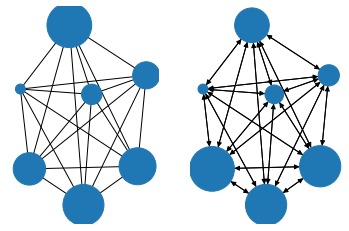

In [3]:
def net(n=7, delta=1):
    N = range(1, n + 1)
    G = nx.complete_graph(N)
    G.graph["dissemination"] = "simple"
    nx.set_node_attributes(G, {m: m for m in N}, "compute")
    nx.set_edge_attributes(G, f"uniform {0.5*delta} {1.5*delta}", "delay")
    return G


plt.subplot(1, 2, 1)
n = net()
lyt = draw(n, size="compute")
r = sim(n, activations=32, protocol="tailstorm 8 discount")
plt.subplot(1, 2, 2)
draw(r, size="reward", layout=lyt)

# Run simulations

In [4]:
ks = [2, 4, 8, 16, 32, 64]
protocols = ["nakamoto", "ethereum"]
protocols += [f"tailstorm {k:02d} {r}" for k in ks for r in ["constant", "discount"]]
protocols += [f"bk {k:02d}" for k in ks]
iterations = range(100)  # reduce this from 1000 to 10 or 100 during development
activations = [1000]
deltas = [1]
activation_delays = [1, 2, 4, 8]
input_df = pd.DataFrame(
    itertools.product(iterations, protocols, deltas, activation_delays, activations),
    columns=["iteration", "protocol", "delta", "activation_delay", "activations"],
)
input_df

,iteration,protocol,delta,activation_delay,activations
0,0,nakamoto,1,1,1000
1,0,nakamoto,1,2,1000
2,0,nakamoto,1,4,1000
3,0,nakamoto,1,8,1000
4,0,ethereum,1,1,1000
...,...,...,...,...,...
7995,99,bk 32,1,8,1000
7996,99,bk 64,1,1,1000
7997,99,bk 64,1,2,1000
7998,99,bk 64,1,4,1000


In [5]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, use_memory_fs=False)


def per_row(r):
    G = sim(
        net(delta=r.delta),
        activation_delay=r.activation_delay,
        protocol=r.protocol,
        activations=r.activations,
        seed=r.iteration,
    )
    r["height"] = G.graph["head_height"]
    r["progress"] = G.graph["head_progress"]
    r["time"] = G.graph["head_time"]
    r["machine_time"] = G.graph["machine_duration"]
    r["node_df"] = pd.DataFrame.from_dict(G.nodes, orient="index")
    return r


run_df = input_df.parallel_apply(per_row, axis=1, result_type="expand")
run_df

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,iteration,protocol,delta,activation_delay,activations,height,progress,time,machine_time,node_df
0,0,nakamoto,1,1,1000,592.0,592.0,1009.091221,0.004540,activations reward compute 1 40.0...
1,0,nakamoto,1,2,1000,720.0,720.0,1957.633050,0.003790,activations reward compute 1 42.0...
2,0,nakamoto,1,4,1000,838.0,838.0,3922.423046,0.003592,activations reward compute 1 27.0...
3,0,nakamoto,1,8,1000,919.0,919.0,8268.914889,0.003765,activations reward compute 1 40.0...
4,0,ethereum,1,1,1000,612.0,917.0,1073.334733,0.005906,activations reward compute 1 4...
...,...,...,...,...,...,...,...,...,...,...
7995,99,bk 32,1,8,1000,30.0,961.0,7777.891900,0.011256,activations reward compute 1 40.0...
7996,99,bk 64,1,1,1000,15.0,961.0,1046.010429,0.016563,activations reward compute 1 41.0...
7997,99,bk 64,1,2,1000,15.0,961.0,2051.270658,0.015796,activations reward compute 1 42.0...
7998,99,bk 64,1,4,1000,15.0,961.0,4040.388710,0.015186,activations reward compute 1 38.0...


In [6]:
acc = []
for i, r in run_df.iterrows():
    n = r["node_df"]
    n["relative_compute"] = n.compute / sum(n.compute)
    n["efficiency"] = (
        n.reward / sum(n.reward) / n.relative_compute
    )  # Loiseau's efficiency, right?
    n["rl_efficiency"] = n.reward / r.progress / n.relative_compute
    for k in r.keys():
        if k not in ["node_df"]:
            n["g_" + k] = r[k]
    acc.append(n)
node_df = pd.concat(acc)
node_df

,activations,reward,compute,relative_compute,efficiency,rl_efficiency,g_iteration,g_protocol,g_delta,g_activation_delay,g_activations,g_height,g_progress,g_time,g_machine_time
1,40.0,13.0,1.0,0.035714,0.614865,0.614865,0,nakamoto,1,1,1000,592.0,592.0,1009.091221,0.004540
2,59.0,26.0,2.0,0.071429,0.614865,0.614865,0,nakamoto,1,1,1000,592.0,592.0,1009.091221,0.004540
3,108.0,53.0,3.0,0.107143,0.835586,0.835586,0,nakamoto,1,1,1000,592.0,592.0,1009.091221,0.004540
4,140.0,88.0,4.0,0.142857,1.040541,1.040541,0,nakamoto,1,1,1000,592.0,592.0,1009.091221,0.004540
5,183.0,111.0,5.0,0.178571,1.050000,1.050000,0,nakamoto,1,1,1000,592.0,592.0,1009.091221,0.004540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,96.0,93.0,3.0,0.107143,0.904167,0.903226,99,bk 64,1,8,1000,15.0,961.0,8161.739114,0.015816
4,152.0,146.0,4.0,0.142857,1.064583,1.063476,99,bk 64,1,8,1000,15.0,961.0,8161.739114,0.015816
5,195.0,188.0,5.0,0.178571,1.096667,1.095525,99,bk 64,1,8,1000,15.0,961.0,8161.739114,0.015816
6,206.0,194.0,6.0,0.214286,0.943056,0.942074,99,bk 64,1,8,1000,15.0,961.0,8161.739114,0.015816


## Inequality

Gini coefficient on efficiency. Efficiency is like in Loiseau's paper: individual reward over sum of rewards and relative compute.

First, we plot all efficiencies in a facet grid with linear estimators. Slope of the line represents inequality.

Then we apply the gini coefficient to compress the results.

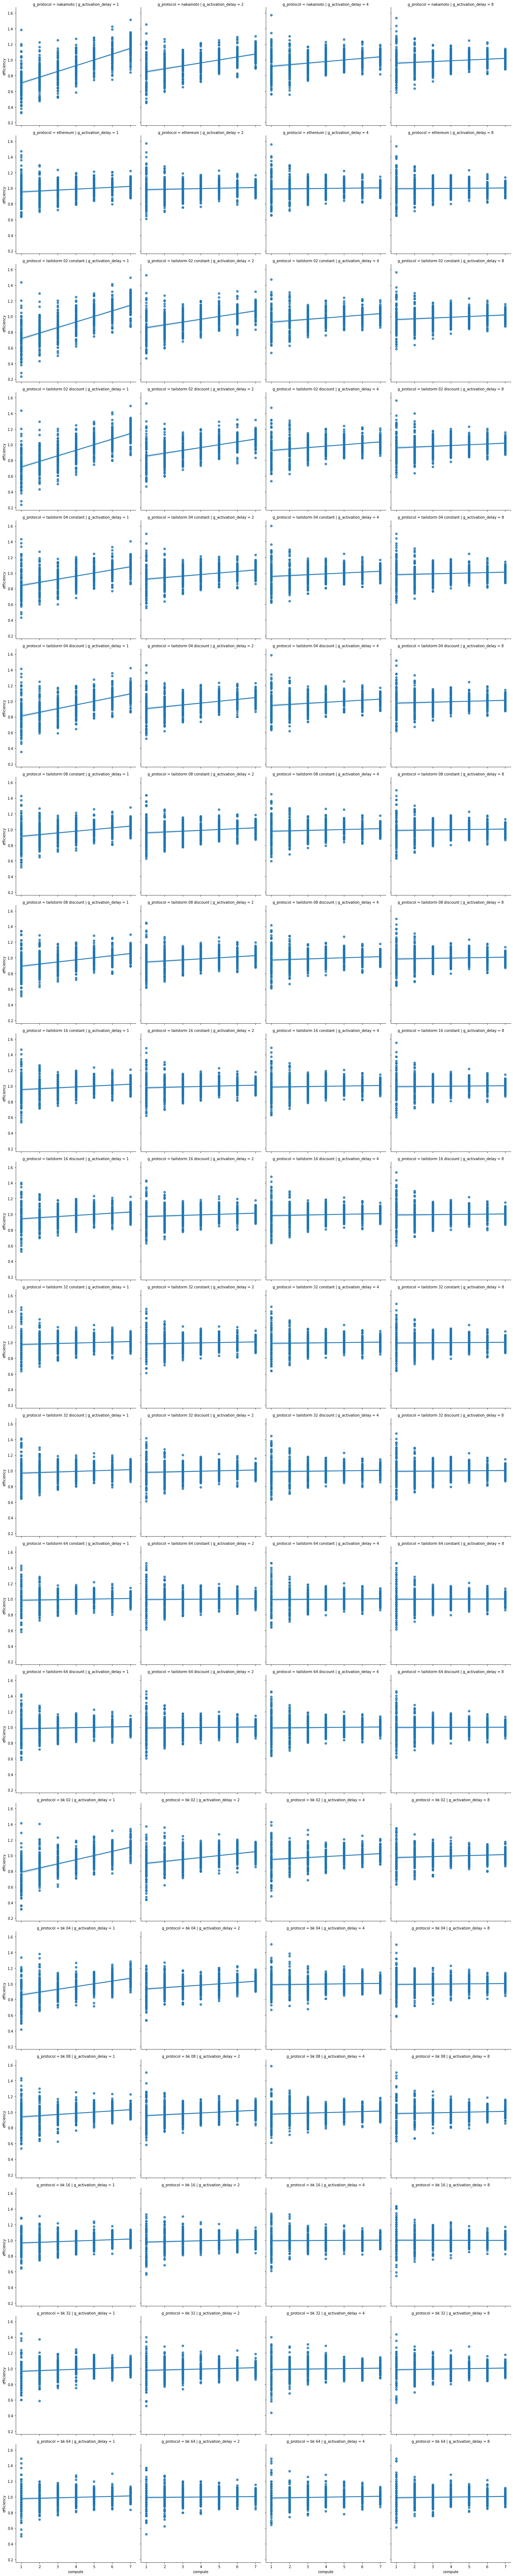

In [7]:
sns.lmplot(
    data=node_df,
    x="compute",
    y="efficiency",
    col="g_activation_delay",
    row="g_protocol",
)

In [8]:
# C&P from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    x = np.array(x)
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


ineq_df = (
    node_df.groupby([x for x in node_df.columns if x.startswith("g_")])
    .agg({"efficiency": [gini], "rl_efficiency": [gini]})
    .reset_index()
    .rename(columns=lambda x: x.removeprefix("g_"))
)
ineq_df.columns = ineq_df.columns.map("_".join).map(lambda x: x.removesuffix("_"))
ineq_df

,iteration,protocol,delta,activation_delay,activations,height,progress,time,machine_time,efficiency_gini,rl_efficiency_gini
0,0,bk 02,1,1,1000,311.0,623.0,1014.835214,0.010443,0.073694,0.073694
1,0,bk 02,1,2,1000,384.0,769.0,2112.816529,0.008846,0.056925,0.056925
2,0,bk 02,1,4,1000,428.0,857.0,4188.168035,0.009329,0.044812,0.044812
3,0,bk 02,1,8,1000,462.0,925.0,8027.377976,0.008336,0.044462,0.044462
4,0,bk 04,1,1,1000,182.0,729.0,1003.238566,0.008784,0.075028,0.075028
...,...,...,...,...,...,...,...,...,...,...,...
7995,99,tailstorm 64 constant,1,8,1000,15.0,960.0,7757.589807,0.268912,0.052703,0.052703
7996,99,tailstorm 64 discount,1,1,1000,15.0,960.0,990.121349,0.769293,0.049739,0.049739
7997,99,tailstorm 64 discount,1,2,1000,15.0,960.0,1965.219902,0.511500,0.049835,0.049835
7998,99,tailstorm 64 discount,1,4,1000,15.0,960.0,3885.751067,0.426065,0.053603,0.053603


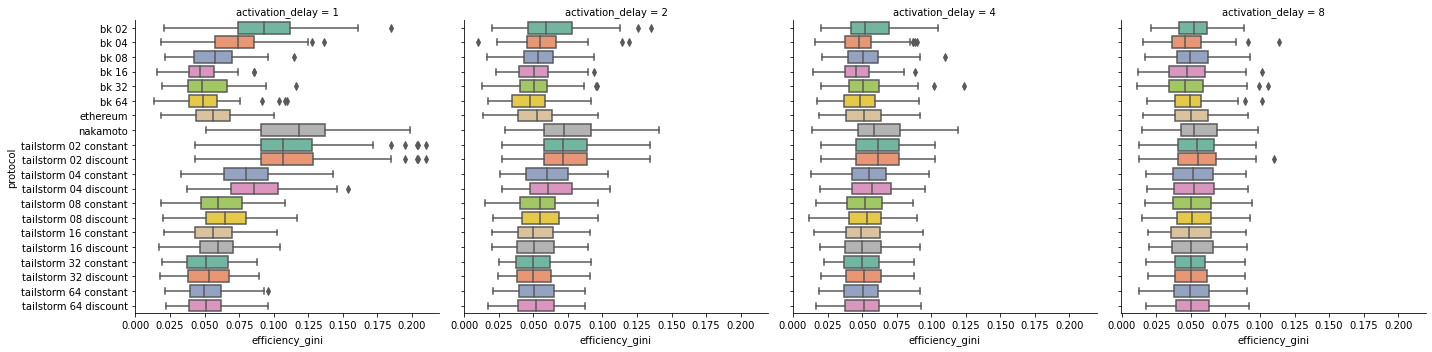

In [9]:
sns.catplot(
    data=ineq_df,
    kind="box",
    y="protocol",
    x="efficiency_gini",
    col="activation_delay",
    palette="Set2",
)

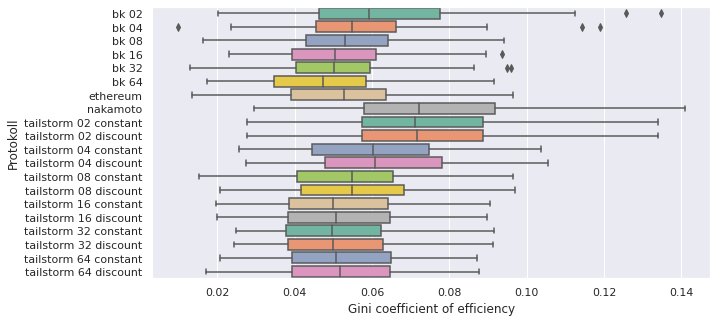

In [10]:
# PDF export for paper draft
sns.set(rc={"figure.figsize": (10, 5)})
ax = sns.boxplot(
    data=ineq_df.query("activation_delay == 2"),
    y="protocol",
    x="efficiency_gini",
    palette="Set2",
)
ax.set(
    xlabel="Gini coefficient of efficiency",
    ylabel="Protokoll",
)
plt.savefig("benign-network-ineq-ad2.pdf", bbox_inches="tight")

## RL/efficiency


For RL, we normalize individual reward by relative compute and progress. This metric captures the discount effect in  tailstorm. The traditional efficiency does not capture the discount effect since it is based on relative rewards.

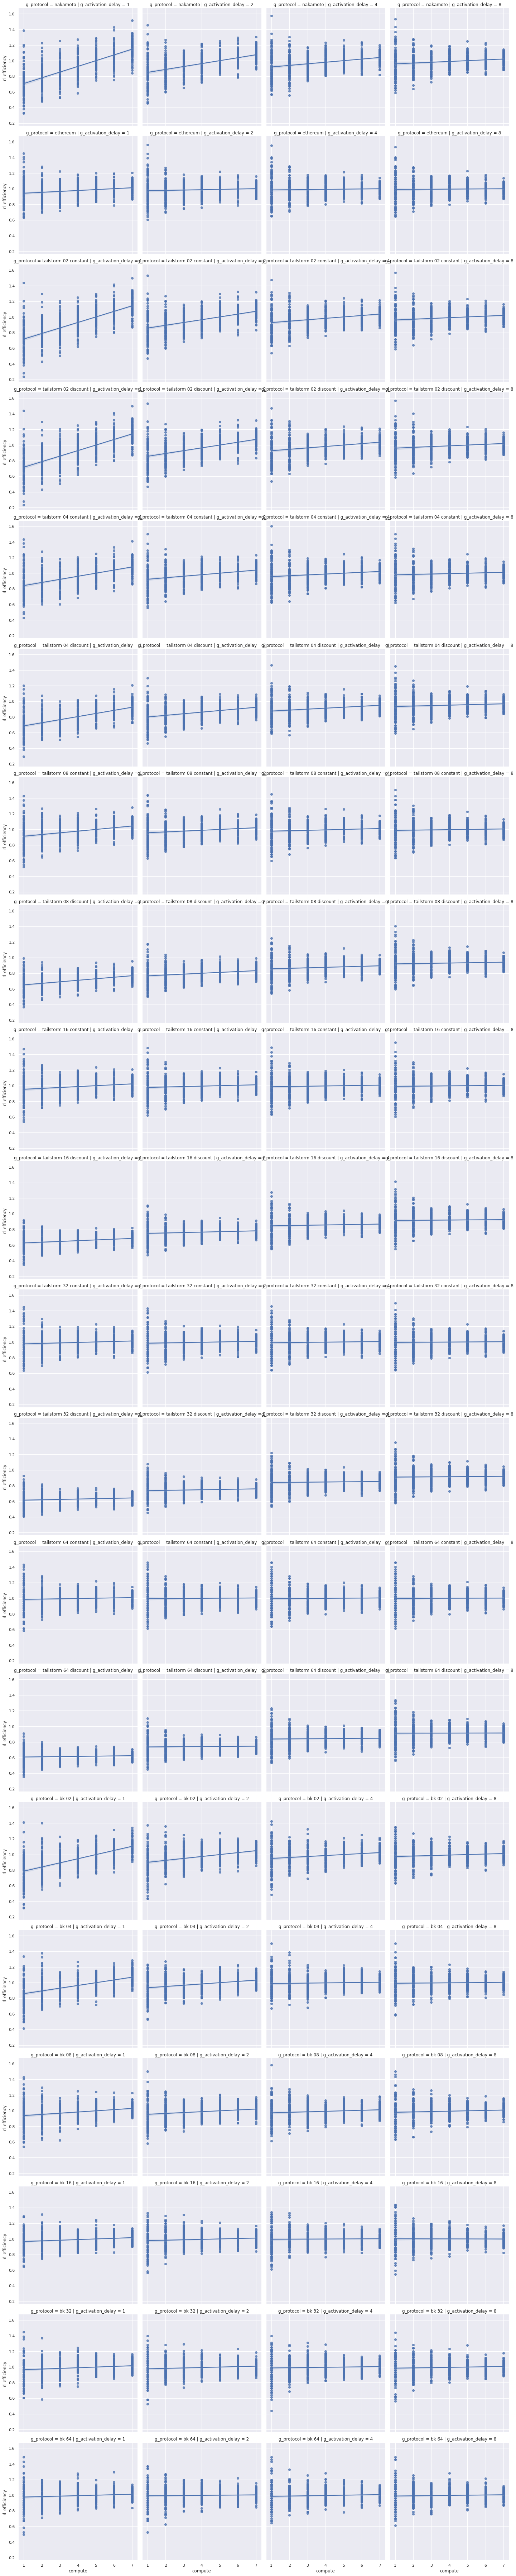

In [11]:
sns.lmplot(
    data=node_df,
    x="compute",
    y="rl_efficiency",
    col="g_activation_delay",
    row="g_protocol",
)

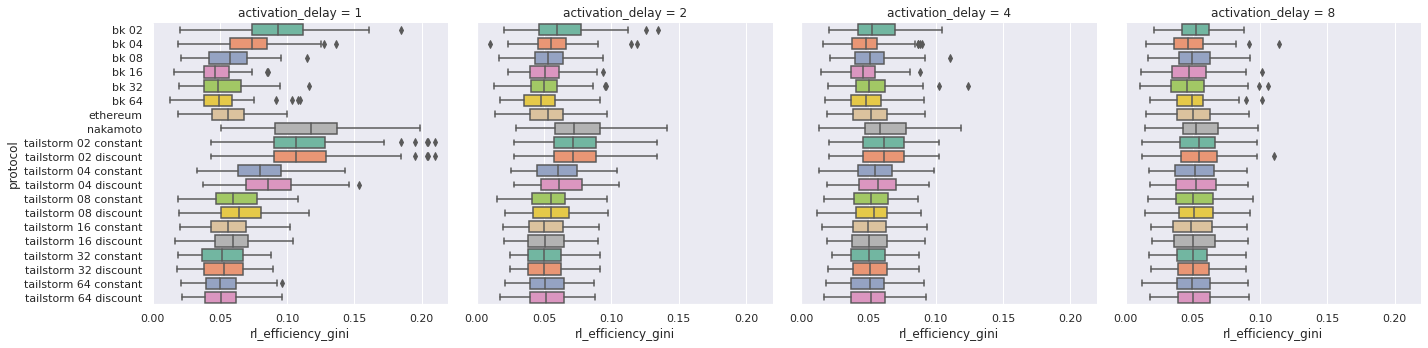

In [12]:
sns.catplot(
    data=ineq_df,
    kind="box",
    y="protocol",
    x="rl_efficiency_gini",
    col="activation_delay",
    palette="Set2",
)

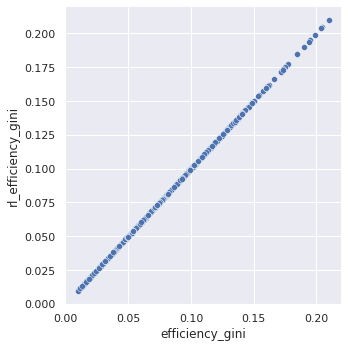

In [13]:
sns.relplot(data=ineq_df, x="efficiency_gini", y="rl_efficiency_gini")